In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords 
from nltk.tokenize import WordPunctTokenizer
import glob
import os
import re
import string
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
import pickle

# IMPORT DATA

In [133]:
# setting the path for joining multiple files with restaurant reviews
files = os.path.join("C:/Users/Elisaveta/Documents/ITMO/НИР/PROJECT/resturaunt_reviews/", "restaurant_*.csv")

# list of merged files returned
files = glob.glob(files)

# joining files with concat and read_csv
reviews_df = pd.concat(map(pd.read_csv, files), ignore_index=True)

In [136]:
reviews_df.head()

,restaurant,adress,name,date,review,rating
0,all Seasons,"Большая Морская ул., 34, Санкт-Петербург, Росс...",Дмитрий Контраст,7 месяцев назад,"Первый раз в данном ресторане, сюда нас пригла...",5
1,all Seasons,"Большая Морская ул., 34, Санкт-Петербург, Росс...",полина никулина,7 месяцев назад,"Итак, в ресторане взяли «Зимний сет». Шеф и по...",3
2,all Seasons,"Большая Морская ул., 34, Санкт-Петербург, Росс...",Maria ignatenko,11 месяцев назад,Очень атмосферное заведение. Шикарная подача б...,5
3,all Seasons,"Большая Морская ул., 34, Санкт-Петербург, Росс...",Ekaterina Bagdasarova,год назад,Ваууууу. Других слов нет!\nРекомендую!\nНеверо...,5
4,all Seasons,"Большая Морская ул., 34, Санкт-Петербург, Росс...",Роман Левин,год назад,"Были в этом ресторане уже дважды, планируем ещ...",5


# PREPROCCESING DATA

In [138]:
#delete Nan values
reviews_df = reviews_df.dropna()

#find mean rating for each restaurant
ratings_dict = reviews_df.groupby('restaurant')['rating'].mean().round(2).to_dict()
reviews_df['mean_rating'] = reviews_df['restaurant'].map(ratings_dict)

<ipython-input-138-218f748fc61e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['mean_rating'] = reviews_df['restaurant'].map(ratings_dict)


In [139]:
reviews_df.head()

,restaurant,adress,name,date,review,rating,mean_rating
0,all Seasons,"Большая Морская ул., 34, Санкт-Петербург, Росс...",Дмитрий Контраст,7 месяцев назад,"Первый раз в данном ресторане, сюда нас пригла...",5,4.67
1,all Seasons,"Большая Морская ул., 34, Санкт-Петербург, Росс...",полина никулина,7 месяцев назад,"Итак, в ресторане взяли «Зимний сет». Шеф и по...",3,4.67
2,all Seasons,"Большая Морская ул., 34, Санкт-Петербург, Росс...",Maria ignatenko,11 месяцев назад,Очень атмосферное заведение. Шикарная подача б...,5,4.67
3,all Seasons,"Большая Морская ул., 34, Санкт-Петербург, Росс...",Ekaterina Bagdasarova,год назад,Ваууууу. Других слов нет!\nРекомендую!\nНеверо...,5,4.67
4,all Seasons,"Большая Морская ул., 34, Санкт-Петербург, Росс...",Роман Левин,год назад,"Были в этом ресторане уже дважды, планируем ещ...",5,4.67


In [140]:
#find stop words
stop = []
for word in stopwords.words('russian'):
    s = [char for char in word if char not in string.punctuation]
    stop.append(''.join(s))
    
for word in stopwords.words('english'):
    s = [char for char in word if char not in string.punctuation]
    stop.append(''.join(s))

In [141]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Lower Casing
    2. Remove all punctuation
    3. Remove all \n substrings
    4. Remove all URLs
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Lower Casing
    mess = mess.lower()
    
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation or char in '«»']
    
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    ## Removal of \n
    n_pattern = re.compile(r'\n')
    nopunc = n_pattern.sub(r' ', nopunc)
    
    ## Removal of URLS
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    nopunc = url_pattern.sub(r'', nopunc)
    
    # Now just remove any stopwords
    return " ".join([word for word in nopunc.split() if word not in stop])

#delete text before translating
def delete_original_text(mess):
    sub1 = "переведено google"
    sub2 = "оригинал"
    
    if sub1 in mess and sub2 not in mess:  
        return mess.split("переведено google")[1]
    elif sub1 in mess and sub2 in mess:        
        # getting index of substrings
        idx1 = mess.index(sub1)
        idx2 = mess.index(sub2)
        res = mess[idx1 + len(sub1) + 1: idx2]
        # length of substring 1 is added to
        # get string from next character
        return res
    else:
        return mess

In [146]:
#apply text_process and delete_original_text functions to review colummn in reviews_df
reviews_df['review'] = reviews_df['review'].apply(text_process)
reviews_df['review'] = reviews_df['review'].apply(delete_original_text)

<ipython-input-146-0c16854bc74a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['review'] = reviews_df['review'].apply(text_process)
<ipython-input-146-0c16854bc74a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['review'] = reviews_df['review'].apply(delete_original_text)


In [147]:
reviews_df

,restaurant,adress,name,date,review,rating,mean_rating
0,all Seasons,"Большая Морская ул., 34, Санкт-Петербург, Росс...",Дмитрий Контраст,7 месяцев назад,первый данном ресторане сюда пригласил олег га...,5,4.67
1,all Seasons,"Большая Морская ул., 34, Санкт-Петербург, Росс...",полина никулина,7 месяцев назад,итак ресторане взяли «зимний сет» шеф повара м...,3,4.67
2,all Seasons,"Большая Морская ул., 34, Санкт-Петербург, Росс...",Maria ignatenko,11 месяцев назад,очень атмосферное заведение шикарная подача бл...,5,4.67
3,all Seasons,"Большая Морская ул., 34, Санкт-Петербург, Росс...",Ekaterina Bagdasarova,год назад,ваууууу других слов рекомендую невероятная авт...,5,4.67
4,all Seasons,"Большая Морская ул., 34, Санкт-Петербург, Росс...",Роман Левин,год назад,ресторане дважды планируем ещё отличная кухня ...,5,4.67
...,...,...,...,...,...,...,...
75194,Ять,"наб. реки Мойки, 16, Санкт-Петербург, Россия, ...",PEDRO MARTINEZ,3 года назад,хорошая еда,4,4.46
75195,Ять,"наб. реки Мойки, 16, Санкт-Петербург, Россия, ...",Rachel Bailes,5 лет назад,попробуйте борщ,5,4.46
75196,Ять,"наб. реки Мойки, 16, Санкт-Петербург, Россия, ...",Berendina Van Straalen,4 года назад,прекрасная игра,4,4.46
75197,Ять,"наб. реки Мойки, 16, Санкт-Петербург, Россия, ...",Алла Шер,год назад,атмосферное,5,4.46


# LATENT FACTOR COLLABORATIVE FILTERING

## Data preparing 

In [64]:
#create user matrix
users_df = reviews_df[['name','review']]
#create restaurant matrix
restaurants_df = reviews_df[['restaurant', 'review']]

#join all reviews into one string for each users in user matrix
users_df = users_df.groupby('name').agg({'review': ' '.join})
#join all reviews into one string for each restaurant in restaurant matrix
restaurants_df = restaurants_df.groupby('restaurant').agg({'review': ' '.join})

In [67]:
#userid vectorizer
users_vectorizer = TfidfVectorizer(tokenizer = WordPunctTokenizer().tokenize, max_features=5000)
users_vectors = users_vectorizer.fit_transform(users_df['review'])
#Business id vectorizer
restaurants_vectorizer = TfidfVectorizer(tokenizer = WordPunctTokenizer().tokenize, max_features=5000)
restaurants_vectors = restaurants_vectorizer.fit_transform(restaurants_df['review'])

In [68]:
user_rating_matrix = pd.pivot_table(reviews_df, values='rating', index=['name'], columns=['restaurant'])

In [19]:
P = pd.DataFrame(users_vectors.toarray(), index=users_df.index, columns=users_vectorizer.get_feature_names())
Q = pd.DataFrame(restaurants_vectors.toarray(), index=restaurants_df.index, columns=restaurants_vectorizer.get_feature_names())

## Matrix factorization

In [18]:
def matrix_factorization(R, P, Q, steps=25, gamma=0.001,lamda=0.02):
    for step in range(steps):
        for i in R.index:
            for j in R.columns:
                if R.loc[i,j]>0:
                    eij=R.loc[i,j]-np.dot(P.loc[i],Q.loc[j])
                    P.loc[i]=P.loc[i]+gamma*(eij*Q.loc[j]-lamda*P.loc[i])
                    Q.loc[j]=Q.loc[j]+gamma*(eij*P.loc[i]-lamda*Q.loc[j])
        e=0
        for i in R.index:
            for j in R.columns:
                if R.loc[i,j]>0:
                    e= e + pow(R.loc[i,j]-np.dot(P.loc[i],Q.loc[j]),2)+lamda*(pow(np.linalg.norm(P.loc[i]),2)+pow(np.linalg.norm(Q.loc[j]),2))
        if e<0.001:
            break
        
    return P,Q

In [ ]:
P, Q = matrix_factorization(user_rating_matrix, P, Q, steps=25, gamma=0.001,lamda=0.02)

## Export model

In [20]:
# Store P, Q and vectorizer in pickle file
output = open('rest_recommendation_model.pkl', 'wb')
pickle.dump(P,output)
pickle.dump(Q,output)
pickle.dump(users_vectorizer,output)
output.close()

## Testing model

In [22]:
words = "ужин с детской комнатой"
test_df= pd.DataFrame([words], columns=['text'])
test_df['text'] = test_df['text'].apply(text_process)
test_vectors = users_vectorizer.transform(test_df['text'])
test_v_df = pd.DataFrame(test_vectors.toarray(), index=test_df.index, columns=users_vectorizer.get_feature_names())

predictItemRating=pd.DataFrame(np.dot(test_v_df.loc[0],Q.T),index=Q.index,columns=['Rating'])
topRecommendations=pd.DataFrame.sort_values(predictItemRating,['Rating'],ascending=[0])[:7]

for i in topRecommendations.index:
    print(reviews_df[reviews_df['restaurant']==i]['restaurant'].iloc[0], 
          reviews_df[reviews_df['restaurant']==i]['mean_rating'].iloc[0],"из 5")
    print(reviews_df[reviews_df['restaurant']==i]['adress'].iloc[0])
    print('')    

Teplo 4.58 из 5
Дом композиторов, Большая Морская ул., 45, Санкт-Петербург, Россия, 190121

Barashki 3.94 из 5
ул. Ефимова, 2, Санкт-Петербург, Россия, 190031

Баклажан 4.27 из 5
Лиговский пр., 30A, Санкт-Петербург, Россия, 191040

EM 4.5 из 5
наб. реки Мойки, 84, Санкт-Петербург, Россия, 190000

Villaggio 4.26 из 5
Тучков пер., 11/5, Санкт-Петербург, Россия, 199004

Большая Кухня 4.31 из 5
Лиговский пр., 30А, Санкт-Петербург, Россия, 191040

Рибай 4.5 из 5
Казанская ул., 3A, Санкт-Петербург, Россия, 191186



# CONTENT BASE RECOMMENDER SYSTEM

## Data preparing

In [113]:
cb_restaurants_df = reviews_df[['restaurant', 'review']]
#join all reviews of restaurant into one string
cb_restaurants_df = cb_restaurants_df.groupby('restaurant',as_index=False).agg({'review': ' '.join})

In [114]:
restaurants_df_2.head(5)

,review,mean_rating,address
restaurant,,,
Amo Cucinare,моему большому сожалению отзыв самый приятный ...,4.44,"Большая Конюшенная ул., 5, Санкт-Петербург, Ро..."
Barashki,отличное расположение повезёт забронировать ст...,3.94,"ул. Ефимова, 2, Санкт-Петербург, Россия, 190031"
Birch,друзья это великолепно интерьер персонал атмос...,4.67,"Кирочная ул., дом 3, Санкт-Петербург, Россия, ..."
Brisket Eat&Fun,отличное место жаль небольшое рассчитано небол...,4.64,"Шведский пер., 2, Санкт-Петербург, Россия, 191186"
Casa Del Мясо,отлично приятно аутентично сводчатый потолок к...,4.48,"Биржевой пр-д, д.6, Санкт-Петербург, Россия, 1..."


In [116]:
#create dictionary with restaurants mean rating 
mean_rating_dict = reviews_df.groupby('restaurant')['rating'].mean().round(2).to_dict()
#create dictionary with restaurants address
address_arr = np.array(reviews_df[['restaurant','adress']].drop_duplicates().reset_index(drop=True))
address_dict={}
for addr in address_arr:
    address_dict[str(addr[0])] = addr[1]

In [117]:
cb_restaurants_df['mean_rating'] = cb_restaurants_df['restaurant'].map(mean_rating_dict)
cb_restaurants_df['address']     = cb_restaurants_df['restaurant'].map(address_dict)

In [118]:
cb_restaurants_df.head()

,restaurant,review,mean_rating,address
0,Amo Cucinare,моему большому сожалению отзыв самый приятный ...,4.44,"Большая Конюшенная ул., 5, Санкт-Петербург, Ро..."
1,Barashki,отличное расположение повезёт забронировать ст...,3.94,"ул. Ефимова, 2, Санкт-Петербург, Россия, 190031"
2,Birch,друзья это великолепно интерьер персонал атмос...,4.67,"Кирочная ул., дом 3, Санкт-Петербург, Россия, ..."
3,Brisket Eat&Fun,отличное место жаль небольшое рассчитано небол...,4.64,"Шведский пер., 2, Санкт-Петербург, Россия, 191186"
4,Casa Del Мясо,отлично приятно аутентично сводчатый потолок к...,4.48,"Биржевой пр-д, д.6, Санкт-Петербург, Россия, 1..."


In [120]:
#Changing data set index by restaurant name
cb_restaurants_df.set_index('restaurant', inplace=True)

##  Word Frequency Distribution

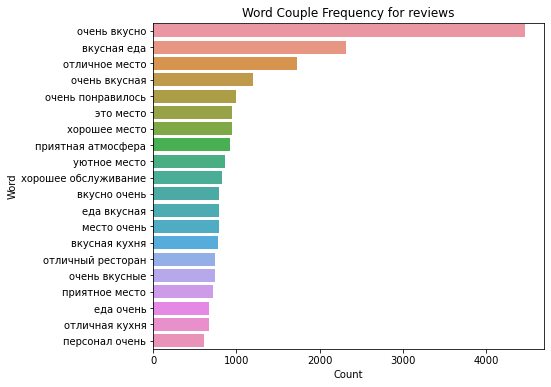

In [119]:
#Word Frequency Distribution
def get_top_words(column, top_nu_of_words, nu_of_word):    
    vec = CountVectorizer(ngram_range= nu_of_word)
    bag_of_words = vec.fit_transform(column)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top_nu_of_words]

#Top 20 two word frequencies for Cuisines
list1 = get_top_words(restaurants_df_2['review'], 20, (2,2))

df_words1 = pd.DataFrame(list1, columns=['Word', 'Count'])

plt.figure(figsize=(7,6))
sns.barplot(data=df_words1, x='Count', y='Word')
plt.title('Word Couple Frequency for reviews');

## TF-IDF method

In [121]:
# Saving indexes in a series
indices = pd.Series(cb_restaurants_df.index)

# Creating tf-idf matrix
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
tfidf_matrix = tfidf.fit_transform(cb_restaurants_df['review'])

# Calculating cosine similarities
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

## Content based recommender system

In [129]:
def recommend(name, cosine_similarities = cosine_similarities):
    # Create a list to put top 10 restaurants
    recommend_restaurant = []
    # Find the index of the restaurant entered
    idx = indices[indices == name].index[0]
    # Find the restaurants with a similar cosine-sim value and order them from bigges number
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending=False)    
    # Extract top 30 restaurant indexes with a similar cosine-sim value
    top30_indexes = list(score_series.iloc[0:31].index)
    
    # Names of the top 30 restaurants
    for each in top30_indexes:
        recommend_restaurant.append(list(restaurants_df_2.index)[each])    
    # Creating the new data set to show similar restaurants
    df_new = pd.DataFrame(columns=[ 'mean_rating', 'address'])
    
    # Create the top 30 similar restaurants with some of their columns
    for each in recommend_restaurant:
        df_new = df_new.append(pd.DataFrame(restaurants_df_2[['mean_rating','address']][restaurants_df_2.index == each].sample()))
    
    
    df_new = df_new.drop([name])
    # Drop the same named restaurants and sort only the top 10 by the highest rating
    df_new = df_new.drop_duplicates(subset=['mean_rating','address'], keep=False)
    df_new = df_new.sort_values(by='mean_rating', ascending=False).head(10)
    
    print('Top %s restaurants like %s with similar reviews: ' % (str(len(df_new)), name))
    
    return df_new

In [130]:
recommend('Duo Asia')

Top 10 restaurants like Duo Asia with similar reviews: 


,mean_rating,address
Schengen,4.73,"Кирочная ул., 5, Санкт-Петербург, Россия, 191028"
Банщики,4.71,"Дегтярная ул., 1А, Санкт-Петербург, Россия, 19..."
Harvest,4.70,"пр. Добролюбова, 11, Санкт-Петербург, Россия, ..."
Грузинский ресторан Хинкальная Гоги,4.70,"Невский пр., 54, Санкт-Петербург, Россия, 191023"
Serbish,4.69,"ул. Пестеля, 8/36, Санкт-Петербург, Россия, 19..."
Ресторан Ферма на финляндском (Доставка),4.68,"Финляндский пр., 1, Санкт-Петербург, Россия, 1..."
Birch,4.67,"Кирочная ул., дом 3, Санкт-Петербург, Россия, ..."
ЭТНОС,4.65,"Кузнечный пер., 8, Санкт-Петербург, Россия, 19..."
Гости,4.61,"Малая Морская ул., 13, Санкт-Петербург, Россия..."
Сулико,4.60,"Казанская ул., 6, Санкт-Петербург, Россия, 190000"


In [155]:
recommend('Birch')

Top 10 restaurants like Birch with similar reviews: 


,mean_rating,address
Meal,4.80,"Литейный пр., 17-19, Санкт-Петербург, Россия, ..."
Schengen,4.73,"Кирочная ул., 5, Санкт-Петербург, Россия, 191028"
Банщики,4.71,"Дегтярная ул., 1А, Санкт-Петербург, Россия, 19..."
Harvest,4.70,"пр. Добролюбова, 11, Санкт-Петербург, Россия, ..."
Грузинский ресторан Хинкальная Гоги,4.70,"Невский пр., 54, Санкт-Петербург, Россия, 191023"
Serbish,4.69,"ул. Пестеля, 8/36, Санкт-Петербург, Россия, 19..."
Северянин,4.68,"Столярный пер., 18/69, Санкт-Петербург, Россия..."
Ресторан Ферма на финляндском (Доставка),4.68,"Финляндский пр., 1, Санкт-Петербург, Россия, 1..."
all Seasons,4.67,"Большая Морская ул., 34, Санкт-Петербург, Росс..."
Duo Asia,4.61,"ул. Рубинштейна, 20, Санкт-Петербург, Россия, ..."
